#### Classification
This notebook applies a Random Forest classification model to delineate wetland extent using the preprocessed raster data.


In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio     
import numpy as np  
import pandas as pd
import math
import seaborn as sns

from collections import Counter
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.transform import rowcol
from rasterio.windows import from_bounds

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.inspection import permutation_importance

from skimage.morphology import opening, square
from scipy.interpolate import griddata


In [2]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"
raster_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\processed_data\cropped_rasters"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")


Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


#### Loading Training Points
Importing and preparing the training point data for use in classification. 

In [18]:
# Define AOI extents
# Central point in decimal degrees
center_lat = 0.6
center_lon = 36.0667

# Define a bounding box: ±0.3° latitude (north-south), ±0.15° longitude (east-west)
lat_buffer = 0.3
lon_buffer = 0.15

# Compute extent (bounding box)
extent = (
    center_lon - lon_buffer,  # xmin (left)
    center_lat - lat_buffer,  # ymin (bottom)
    center_lon + lon_buffer,  # xmax (right)
    center_lat + lat_buffer   # ymax (top)
)

print("Computed extent:", extent)

# Load training points and reproject to match LST raster CRS if needed
gdf = gpd.read_file(os.path.join(base_dir, 'baringo_training_points.shp'))
with rasterio.open(os.path.join(base_dir, "input/DEM", "dem.tif")) as src:
    dem_crs = src.crs
if gdf.crs != dem_crs:
    gdf = gdf.to_crs(dem_crs)

gdf.head()


Computed extent: (35.9167, 0.3, 36.216699999999996, 0.8999999999999999)


,id,class,geometry
0,1,water,POINT (36.06711 0.56802)
1,2,water,POINT (36.04937 0.67043)
2,3,water,POINT (36.09725 0.47869)
3,4,water,POINT (36.09869 0.47104)
4,5,water,POINT (36.07187 0.34713)


### Generate convex hull

Training points inside convex hull: 48


C:\Users\Ethel Ogallo\AppData\Local\Temp\ipykernel_15320\2581588515.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  wetwater_union = wetwater_gdf.unary_union  # Merge geometries


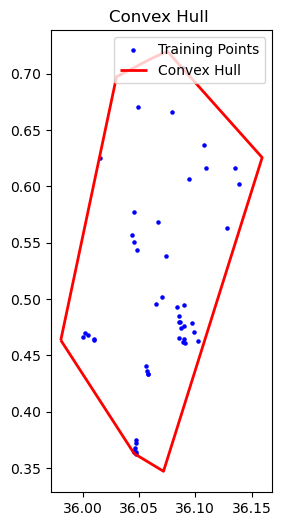

In [ ]:
from shapely.geometry import MultiPoint

# Select wetland and water training points
wetwater_gdf = gdf[gdf['class'].isin(['wetland', 'water'])]

# Create a convex hull polygon from wetland + water points
wetwater_union = wetwater_gdf.unary_union  # Merge geometries
wetwater_hull = wetwater_union.convex_hull  # Convex hull polygon

# Wrap the convex hull in a GeoDataFrame for saving or plotting
hull_gdf = gpd.GeoDataFrame(geometry=[wetwater_hull], crs=gdf.crs)

# Filter all training points to only those inside the hull (keep all classes)
gdf_in_hull = gdf[gdf.geometry.within(wetwater_hull)].copy()
print(f"Training points inside convex hull: {len(gdf_in_hull)}")

# Plot to verify
fig, ax = plt.subplots(figsize=(6,6))
gdf_in_hull.plot(ax=ax, color='blue', markersize=5, label='Training Points')
hull_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label='Convex Hull')
plt.legend()
plt.title("Convex Hull ")
plt.show()

#### Stacking All Raster Data
Combining all individual raster layers into a single multi-band raster stack, ensuring all layers are properly aligned and clipped to the area of interest (AOI)

In [20]:
# Temporal layers 
temporal_names = ["LST", "NDWI", "NDVI_SD", "NDVI_range", "VV", "VH"]

# Static layers 
static_names = ["DEM", "Slope", "TWI"]

feature_stack_by_year = {}

for year in range(2015, 2026):
    layers, layer_names = [], []

    # Load temporal layers
    for name in temporal_names:
        path = os.path.join(raster_dir, str(year), f"{name}.tif")
        if os.path.exists(path):
            with rasterio.open(path) as src:
                arr = src.read(1)
                layers.append(arr)
                layer_names.append(name)
        else:
            print(f"Year {year}: Missing temporal layer '{name}'")

    # Load static layers (from the same static folder or from any year folder)
    for name in static_names:
        path = os.path.join(raster_dir, str(year), f"{name}.tif")
        if os.path.exists(path):
            with rasterio.open(path) as src:
                arr = src.read(1)
                layers.append(arr)
                layer_names.append(name)
        else:
            print(f"Year {year}: Missing static layer '{name}'")

    # Check shapes and stack
    if len(layers) >= 2 and len(set(arr.shape for arr in layers)) == 1:
        stack = np.stack(layers, axis=-1)   # shape: (height, width, num_layers)
        feature_stack_by_year[year] = {
            "stack": stack,
            "layer_names": layer_names
        }
        print(f"Year {year}: Stacked {len(layers)} layers -> stack shape: {stack.shape}")
    else:
        print(f"Year {year}: Missing or mismatched layers; skipped.")


Year 2015: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2016: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2017: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2018: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2019: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2020: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2021: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2022: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2023: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2024: Stacked 9 layers -> stack shape: (2222, 1113, 9)
Year 2025: Stacked 9 layers -> stack shape: (2222, 1113, 9)


##### Extracting Pixel Values at Training Points
Sampling raster feature values at the locations of training points to create the input data for model training.

In [35]:
# Get transform of cropped DEM once, since extent is the same for all years
dem_path = os.path.join(raster_dir, "2020", "DEM.tif")
with rasterio.open(dem_path) as src:
    window = from_bounds(*extent, transform=src.transform)
    cropped_transform = src.window_transform(window)

# Prepare list of (x, y) coordinates from the training points GeoDataFrame
coords = [(geom.x, geom.y) for geom in gdf.geometry]

# Initialize dict 
if 'training_data_by_year' not in globals():
    training_data_by_year = {}

for year, data in feature_stack_by_year.items():
    feature_stack = data['stack']
    transform = cropped_transform

    # Convert (x, y) coordinates to raster (row, col)
    rows_cols = [rowcol(transform, x, y) for x, y in coords]

    pixels, labels = [], []
    for (row, col), label in zip(rows_cols, gdf["class"]):
        # Check bounds
        if 0 <= row < feature_stack.shape[0] and 0 <= col < feature_stack.shape[1]:
            px_values = feature_stack[row, col, :]
            # Ignore if any value is NaN
            if not np.any(np.isnan(px_values)):
                pixels.append(px_values)
                labels.append(label)

    # Convert to numpy arrays
    X = np.array(pixels)
    y = np.array(labels)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Store
    training_data_by_year[year] = {
        "X": X,
        "y": y_encoded,
        "label_encoder": le
    }

    print(f"Year {year}: extracted {len(y)} samples with {X.shape[1]} features")


Year 2015: extracted 75 samples with 9 features
Year 2016: extracted 75 samples with 9 features
Year 2017: extracted 75 samples with 9 features
Year 2018: extracted 75 samples with 9 features
Year 2019: extracted 75 samples with 9 features
Year 2020: extracted 75 samples with 9 features
Year 2021: extracted 75 samples with 9 features
Year 2022: extracted 75 samples with 9 features
Year 2023: extracted 75 samples with 9 features
Year 2024: extracted 75 samples with 9 features
Year 2025: extracted 75 samples with 9 features


In [49]:
year = 2020
df_samples = pd.DataFrame(training_data_by_year[year]['X'], columns=layer_names)
df_samples['class'] = training_data_by_year[year]['y']
df_samples.iloc[:-10]

,LST,NDWI,NDVI_SD,NDVI_range,VV,VH,DEM,Slope,TWI,class
0,27.191060,-0.262071,0.085111,0.351213,-30.549434,-37.320474,973.000000,0.000000,16.488495,2
1,25.615673,-0.214967,0.112453,0.456827,-28.480604,-36.581710,973.000000,0.000000,13.045266,2
2,27.631878,0.467113,0.164598,0.870581,-27.010121,-34.865595,978.000000,0.000000,24.284060,2
3,30.020006,0.620334,0.030479,0.136638,-14.666354,-19.937652,978.527100,0.265356,14.028280,2
4,26.643190,0.238816,0.076593,0.339815,-28.451233,-35.641219,995.757324,0.464091,14.679558,2
...,...,...,...,...,...,...,...,...,...,...
60,32.169325,0.602708,0.035280,0.140680,-15.698984,-20.352275,1007.488831,0.351558,8.485535,3
61,33.025086,0.557671,0.031242,0.108748,-17.159700,-22.015522,1006.782166,0.407130,10.566419,3
62,31.789686,0.635135,0.036554,0.133371,-16.413605,-21.238023,1007.281799,0.245018,10.689808,3
63,31.143893,0.550960,0.035582,0.184891,-16.982933,-22.394302,1004.799683,0.318497,10.505600,3


#### Stratified 5-Fold Cross-Validation with Random Forest
This section covers training the Random Forest classifier using the prepared training dataset.
The stratified 5-fold cross-validation is applied to evaluate model performance, ensuring each fold preserves the class distribution.

The workflow includes both combined train/test splitting and cross-validation to optimize and validate the classification model. 


In [50]:
def train_model_per_year(year, training_data, test_size=0.2, n_estimators_cv=100, n_estimators_final=200, random_state=42):
    """
    Train Random Forest model for each year with train/test split and cross-validation.
    
    Returns:
        model: final trained model on combined train+val
        metrics: dict with CV and test accuracies and predictions
    """
    data = training_data[year]
    X, y, le = data["X"], data["y"], data["label_encoder"]

    from collections import Counter
    class_counts = Counter(y)
    min_class_count = min(class_counts.values())

    if min_class_count < 2:
        print(f"Warning: Year {year} has class with less than 2 samples. Skipping stratified split and CV.")

        # Train final model on all data (no split)
        final_rf = RandomForestClassifier(n_estimators=n_estimators_final, random_state=random_state)
        final_rf.fit(X, y)

        metrics = {
            "cv_true": None,
            "cv_pred": None,
            "cv_accuracy": None,
            "y_test": None,
            "y_test_pred": None,
            "test_accuracy": None,
            "label_encoder": le,
        }
        return final_rf, metrics

    # Proceed with stratified split since all classes have >= 2 samples
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Cross-validation training
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_true, cv_pred = [], []
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        rf = RandomForestClassifier(n_estimators=n_estimators_cv, random_state=random_state)
        rf.fit(X_train_val[train_idx], y_train_val[train_idx])
        y_val_pred = rf.predict(X_train_val[val_idx])
        cv_true.extend(y_train_val[val_idx])
        cv_pred.extend(y_val_pred)

    cv_accuracy = accuracy_score(cv_true, cv_pred)

    # Final model on combined train+val
    final_rf = RandomForestClassifier(n_estimators=n_estimators_final, random_state=random_state)
    final_rf.fit(X_train_val, y_train_val)

    # Test set evaluation
    y_test_pred = final_rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    metrics = {
        "cv_true": cv_true,
        "cv_pred": cv_pred,
        "cv_accuracy": cv_accuracy,
        "y_test": y_test,
        "y_test_pred": y_test_pred,
        "test_accuracy": test_accuracy,
        "label_encoder": le,
    }

    return final_rf, metrics



Using the trained Random Forest model, the wetland classes on the study area is predicted.
Following classification, the area covered by each wetland class is estimated in hectares (Ha).

In [51]:
# Train model for a specific year
def prediction_per_year(year, model, feature_stack_by_year, extent, label_encoder):
    """
    Predict classification raster for one year and compute area per class.
    
    Returns:
        pred_img: 2D numpy array of predictions with -1 outside AOI
        class_areas: dict of class names to area in hectares
    """
    feature_stack = feature_stack_by_year[year]["stack"]
    flat = feature_stack.reshape(-1, feature_stack.shape[-1])
    valid_mask = ~np.isnan(flat).any(axis=1)

    pred = np.full(flat.shape[0], -1, dtype=int)
    pred[valid_mask] = model.predict(flat[valid_mask])
    pred_img = pred.reshape(feature_stack.shape[:2])

    counts = Counter(pred_img[pred_img >= 0])

    # Calculate pixel area in hectares
    lat = (extent[1] + extent[3]) / 2
    deg_to_m = 111320  # meters per degree
    pixel_w = abs(extent[2] - extent[0]) / pred_img.shape[1]
    pixel_h = abs(extent[3] - extent[1]) / pred_img.shape[0]
    pixel_area_ha = (pixel_w * deg_to_m * math.cos(math.radians(lat))) * (pixel_h * deg_to_m) / 10_000

    class_areas = {
        label_encoder.inverse_transform([cls])[0]: count * pixel_area_ha for cls, count in counts.items()
    }

    return pred_img, class_areas

In [52]:
models_by_year = {}
metrics_by_year = {}
predictions_by_year = {}

for year in sorted(training_data_by_year.keys()):
    print(f"\nProcessing year {year}...")

    # Train model
    model, metrics = train_model_per_year(year, training_data_by_year)
    models_by_year[year] = model
    metrics_by_year[year] = metrics

    print(f"Year {year} CV Accuracy: {metrics['cv_accuracy']:.4f}")
    print(f"Year {year} Test Accuracy: {metrics['test_accuracy']:.4f}")

    # Predict
    pred_img, class_areas = prediction_per_year(year, model, feature_stack_by_year, extent, metrics["label_encoder"])
    predictions_by_year[year] = {
        "pred_img": pred_img,
        "class_areas": class_areas,
    }

    print(f"Prediction complete for year {year}.")          


Processing year 2015...
Year 2015 CV Accuracy: 0.8667
Year 2015 Test Accuracy: 0.9333
Prediction complete for year 2015.

Processing year 2016...
Year 2016 CV Accuracy: 0.8167
Year 2016 Test Accuracy: 0.8667
Prediction complete for year 2016.

Processing year 2017...
Year 2017 CV Accuracy: 0.8500
Year 2017 Test Accuracy: 0.8667
Prediction complete for year 2017.

Processing year 2018...
Year 2018 CV Accuracy: 0.8167
Year 2018 Test Accuracy: 0.8000
Prediction complete for year 2018.

Processing year 2019...
Year 2019 CV Accuracy: 0.8500
Year 2019 Test Accuracy: 0.8667
Prediction complete for year 2019.

Processing year 2020...
Year 2020 CV Accuracy: 0.8833
Year 2020 Test Accuracy: 0.8667
Prediction complete for year 2020.

Processing year 2021...
Year 2021 CV Accuracy: 0.8667
Year 2021 Test Accuracy: 0.8667
Prediction complete for year 2021.

Processing year 2022...
Year 2022 CV Accuracy: 0.8667
Year 2022 Test Accuracy: 0.9333
Prediction complete for year 2022.

Processing year 2023...

#### Confusion Matrix
Evaluating classification accuracy by comparing predicted classes against true labels using a confusion matrix.

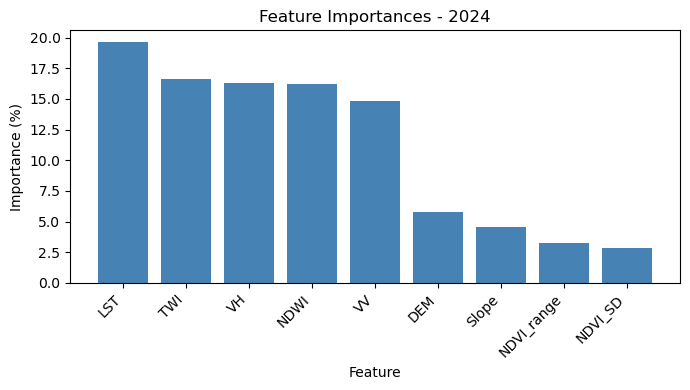


=== 2024 Test set Classification Report ===
              precision    recall  f1-score   support

      forest       0.75      1.00      0.86         3
   rangeland       0.50      0.50      0.50         2
       water       0.67      1.00      0.80         4
     wetland       1.00      0.50      0.67         6

    accuracy                           0.73        15
   macro avg       0.73      0.75      0.71        15
weighted avg       0.79      0.73      0.72        15



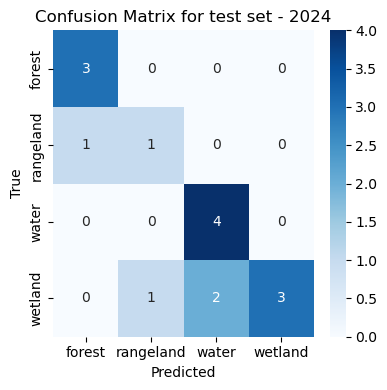


=== Estimated area per class for year 2024:
  forest: 94228.25 ha
  rangeland: 78200.95 ha
  wetland: 23091.57 ha
  water: 24800.57 ha


In [53]:
year = 2024  # change as needed

# The trained RF model
rf_model = models_by_year[year]

# Define feature names (matching the actual feature stack order)
features = ['LST', 'NDWI', 'NDVI_SD','NDVI_range', 'TWI','VV', 'VH', 'DEM', 'Slope'] 

importances = (rf_model.feature_importances_) * 100
idx = importances.argsort()[::-1]

plt.figure(figsize=(7, 4))
plt.bar(np.array(features)[idx], importances[idx], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title(f"Feature Importances - {year}")
plt.ylabel("Importance (%)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# model test results metrics
le = metrics_by_year[year]['label_encoder']
y_test = metrics_by_year[year]['y_test']
y_test_pred = metrics_by_year[year]['y_test_pred']

print(f"\n=== {year} Test set Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Plot confusion matrix
#cv_true = metrics_by_year[year]['cv_true']
#cv_pred = metrics_by_year[year]['cv_pred']
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for test set - {year}')
plt.tight_layout()
plt.show()

print(f"\n=== Estimated area per class for year {year}:")
for cls, area in predictions_by_year[year]['class_areas'].items():
    print(f"  {cls}: {area:.2f} ha")


#### Visualization of Yearly classification
Displaying the predicted wetland classification results for each year.

In [ ]:
years = sorted(predictions_by_year.keys())  
n_years = len(years)

# Setup colormap and norm 
le = metrics_by_year[years[0]]['label_encoder']
labels = le.classes_
cmap = ListedColormap(['#145a32', '#abb2b9', '#3498db', '#f39c12'][:len(labels)])
norm = BoundaryNorm(np.arange(len(labels)+1)-0.5, cmap.N)
xmin, ymin, xmax, ymax = extent


# Define subplot grid size (2 rows, adjust columns)
nrows = 2
ncols = (n_years + 1) // 2

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows))
axes = axes.flatten()

for ax, year in zip(axes, years):
    pred_img = predictions_by_year[year]['pred_img']

    im = ax.imshow(pred_img, cmap=cmap, norm=norm, 
                   extent=[xmin, xmax, ymin, ymax], origin='upper')
    ax.set_title(f"Classification Prediction for {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')

    # Add colorbar per subplot
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(len(labels)))
    cbar.ax.set_yticklabels(labels)
    cbar.set_label("Class")

# Remove empty subplots if any
for ax in axes[n_years:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [54]:
year = 2024
pred_img = predictions_by_year[year]['pred_img']


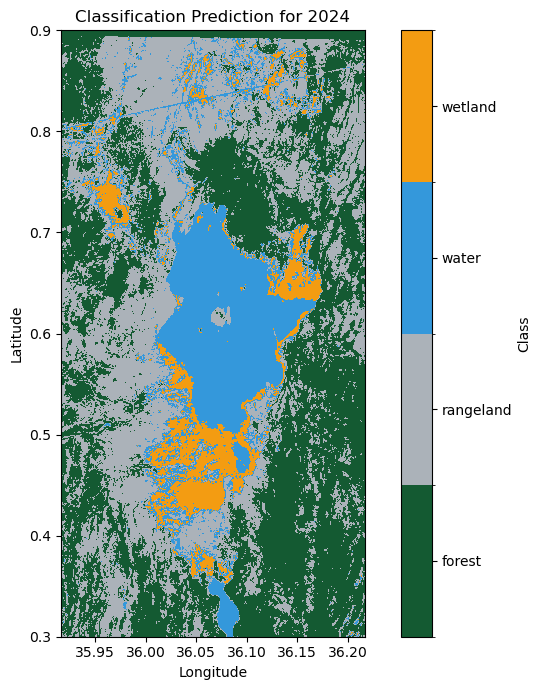

In [55]:
fig, ax = plt.subplots(figsize=(8, 7))
# Setup colormap and norm 
le = metrics_by_year[year]['label_encoder']
labels = le.classes_
cmap = ListedColormap(['#145a32', '#abb2b9', '#3498db', '#f39c12'][:len(labels)])
norm = BoundaryNorm(np.arange(len(labels)+1)-0.5, cmap.N)
xmin, ymin, xmax, ymax = extent

im = ax.imshow(pred_img, cmap=cmap, norm=norm, 
               extent=[xmin, xmax, ymin, ymax], origin='upper')
ax.set_title(f"Classification Prediction for {year}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')

cbar = fig.colorbar(im, ax=ax, ticks=np.arange(len(labels)))
cbar.ax.set_yticklabels(labels)
cbar.set_label("Class")

plt.tight_layout()
plt.show()



In [ ]:
# save the predictions for the year 2024
out_tif = f"C:\\Users\\Ethel Ogallo\\Documents\\ZFL1\\Data\\classification_{year}.tif"
 

with rasterio.open(
    out_tif, 'w', driver='GTiff',
    height=pred_img.shape[0], width=pred_img.shape[1],
    count=1, dtype=pred_img.dtype,
    crs=dem_crs, transform=cropped_transform
) as dst:
    dst.write(pred_img, 1)
